<a href="https://colab.research.google.com/github/ssawant/CNN/blob/main/Image_Segmentation_with_tensorflow(U_Net).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation

In Image classification we have seen that a task of the network is to assign a label or class to an input image. However, suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

In [70]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [71]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [72]:
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [73]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

In [74]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [75]:
dataset['train'].take(1)

<TakeDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>

In [76]:
# normalize image
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [77]:
# image resizing and argumentation
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128,128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [78]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128,128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

  input_image, input_mask = normalize(input_image, input_mask)
  
  return input_image, input_mask


we are going to use same train - test split as used in tfds

In [79]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
AUTOTUNE = tf.data.AUTOTUNE

In [80]:
train = dataset['train'].map(load_image_train, num_parallel_calls=AUTOTUNE)
test = dataset['test'].map(load_image_test)

create data pipeline 

In [81]:
train_ds = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(AUTOTUNE)
test_ds = test.batch(BATCH_SIZE)

In [82]:
# display some images 
def display(display_list):
  plt.figure(figsize=(10,10))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

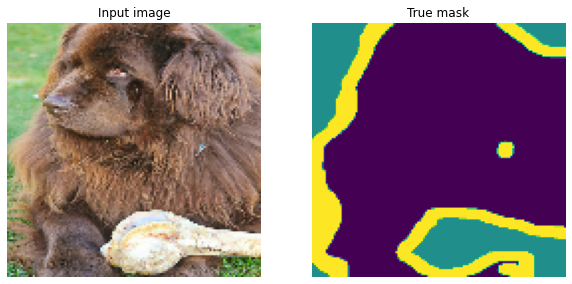

In [83]:
for image, mask in train.take(8):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Define the model

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block

In [84]:
OUTPUT_CHANNELS = 3

Transfer learning using MobileNetV2 model

In [85]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.



In [86]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [87]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128,128,3])

  # Downloading through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Unsampling and establising he skip connection
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
  
  # this is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128
  
  return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model

In [88]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

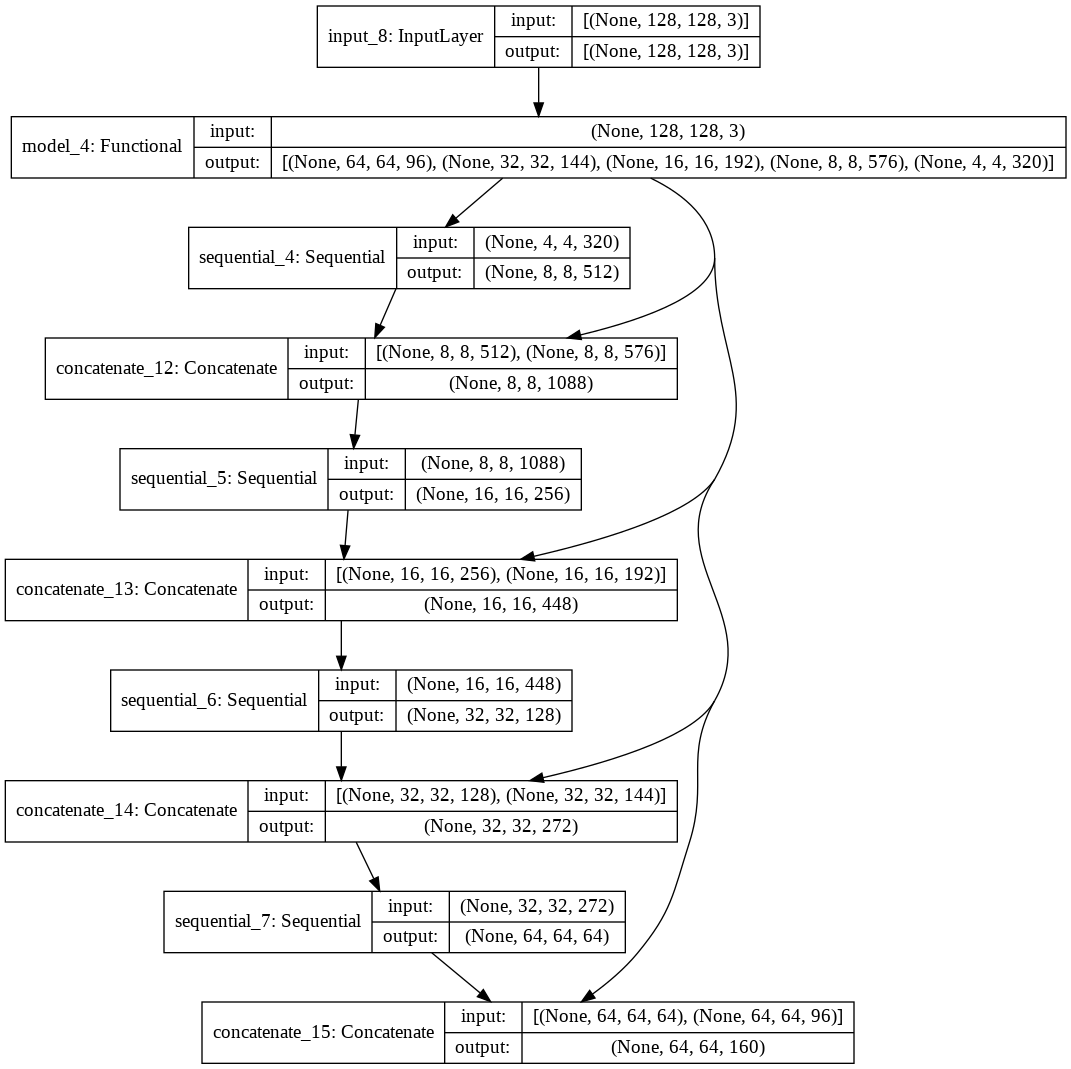

In [89]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [90]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [91]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

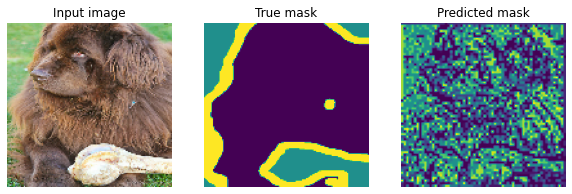

In [92]:
show_predictions()

In [100]:
# sample images during training

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [94]:
EPOCH = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

In [ ]:
model_history = model.fit(train_ds, epochs=EPOCH,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=VALIDATION_STEPS,validation_data=test_ds)
 #callbacks=[DisplayCallback()]

In [ ]:
# plot train val loss and accuracy

def plot_results(history, metrics):
  plt.figure(figsize=(10,6))
  plt.plot(history.history[metrics], 'b', label=metrics )
  plt.plot(history.history['val_'+metrics], 'b', label='val_'+metrics )
  plt.legend(loc='best')
  plt.show()